## **More advanced EDA** ⚙️

Let's apply some more advanced EDA techniques. First, let's handle the data imputation part.

In [19]:
from sklearn.impute import KNNImputer
import pandas as pd

# Loading data
file_path = r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\dropped_rows_columns.csv'
data = pd.read_csv(file_path)

# Initializing the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Applying the imputer to the numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Handling columns with all missing values
columns_with_all_missing = numerical_data.columns[numerical_data.isnull().all()].tolist()
numerical_data = numerical_data.drop(columns=columns_with_all_missing)

imputed_data = pd.DataFrame(imputer.fit_transform(numerical_data), columns=numerical_data.columns)

# Combining imputed numerical data with non-numerical data
data_imputed = data.copy()
data_imputed[numerical_data.columns] = imputed_data

# Re-adding columns that had all missing values, if necessary
for col in columns_with_all_missing:
    data_imputed[col] = data[col]

# Exporting the dataset to the same folder
output_path = r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\dropped_rows_columns_imputed.csv'
data_imputed.to_csv(output_path, index=False)

print(f"Dataset saved to {output_path}")

Dataset saved to D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\dropped_rows_columns_imputed.csv


Next, let's perform outlier detection using isolation forest and visualize the results.

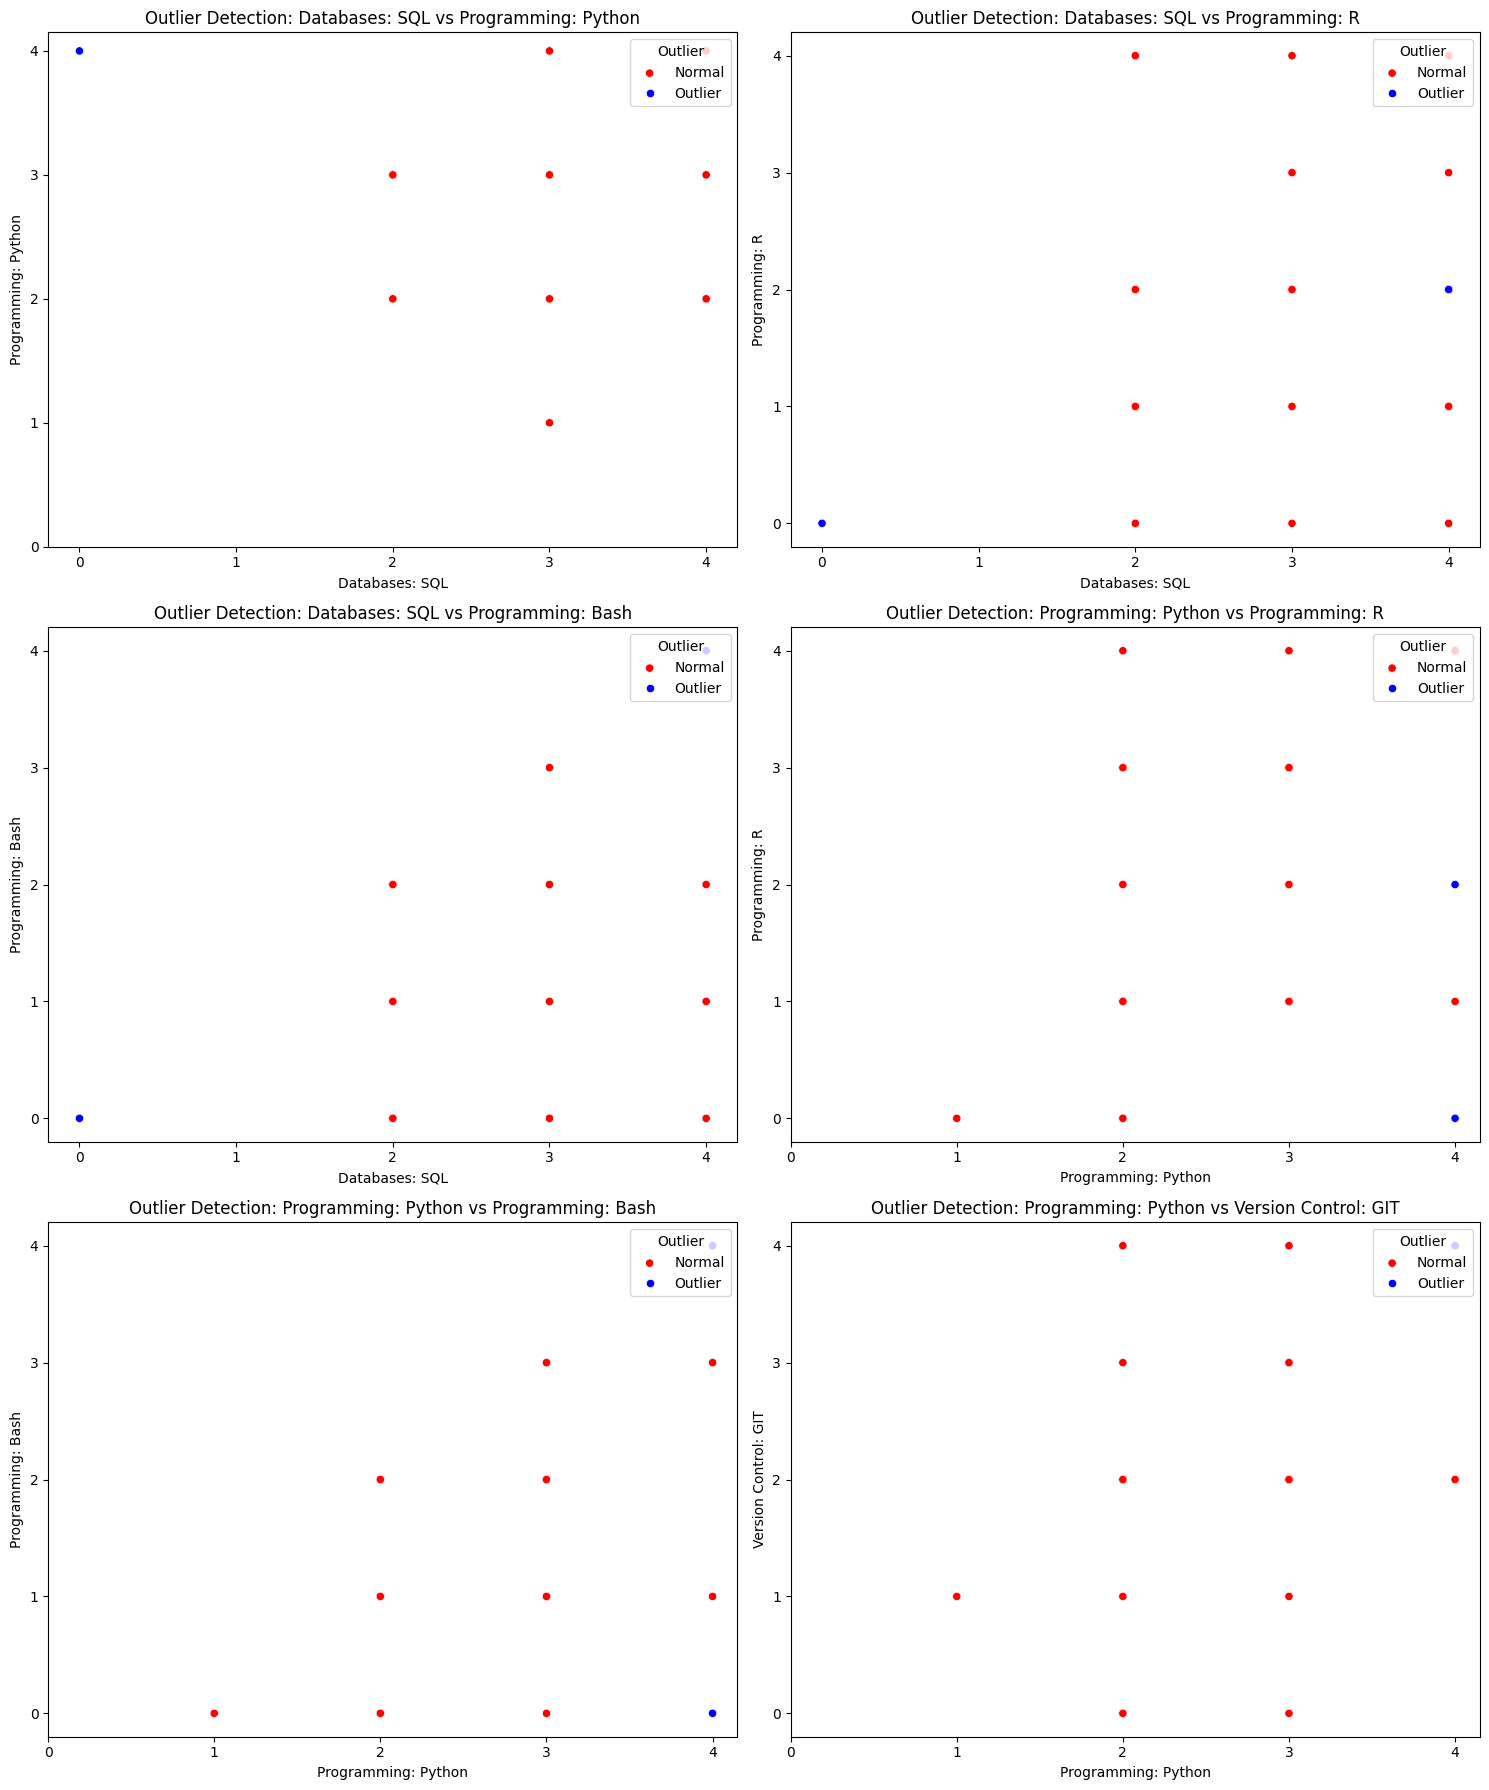

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import math
from sklearn.ensemble import IsolationForest

# Loading the dataset
file_path = r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\dropped_rows_columns_imputed.csv'
imputed_data = pd.read_csv(file_path)

# Identifying non-numeric columns in the dataset
non_numeric_columns = imputed_data.select_dtypes(exclude=['number']).columns.tolist()

# Dropping non-numeric columns from the dataset
imputed_data_hard_skills_actual_cleaned = imputed_data.drop(columns=[col for col in non_numeric_columns if col in imputed_data.columns])

# Initializing the isolation forest
iso_forest_hard_skills_actual_cleaned = IsolationForest(contamination=0.05)

# Fitting the model and predict outliers
outliers_hard_skills_actual_cleaned = iso_forest_hard_skills_actual_cleaned.fit_predict(imputed_data_hard_skills_actual_cleaned)

# Adding the outliers to the dataset
imputed_data['Outlier'] = outliers_hard_skills_actual_cleaned

# Recreating the plots without 0.5s on the axes, using only integer values
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Defining the pairs of hard skills to visualize with 'Databases: SQL' and 'Programming: Python' being primary
skill_pairs = [
    ('Databases: SQL', 'Programming: Python'),
    ('Databases: SQL', 'Programming: R'),
    ('Databases: SQL', 'Programming: Bash'),
    ('Programming: Python', 'Programming: R'),
    ('Programming: Python', 'Programming: Bash'),
    ('Programming: Python', 'Version Control: GIT')
]

# Creating scatter plots for each pair
for (skill_x, skill_y), ax in zip(skill_pairs, axes.flatten()):
    sns.scatterplot(data=imputed_data, x=skill_x, y=skill_y, hue='Outlier', palette=['blue', 'red'], ax=ax)
    ax.set_title(f'Outlier Detection: {skill_x} vs {skill_y}')
    ax.set_xlabel(skill_x)
    ax.set_ylabel(skill_y)
    ax.set_xticks(range(0, int(imputed_data[skill_x].max()) + 1))
    ax.set_yticks(range(0, int(imputed_data[skill_y].max()) + 1))
    ax.legend(title='Outlier', loc='upper right', labels=['Normal', 'Outlier'])

plt.tight_layout()
plt.show()

We can observe that:
- The outliers in these plots represent individuals who have a unique combination of skills compared to the rest of the population.

- Most individuals (blue points) have skill combinations that are similar to each other, and they cluster around common values.

- The presence of outliers across different skill pairs suggests that the dataset has a few individuals with distinctive skill profiles.

##### Now let's check correlations between different numerical values respesenting competency areas by using correlation matrix.

In [21]:
# Dataset loading
data = pd.read_csv(r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\cleaned_dataset.csv')

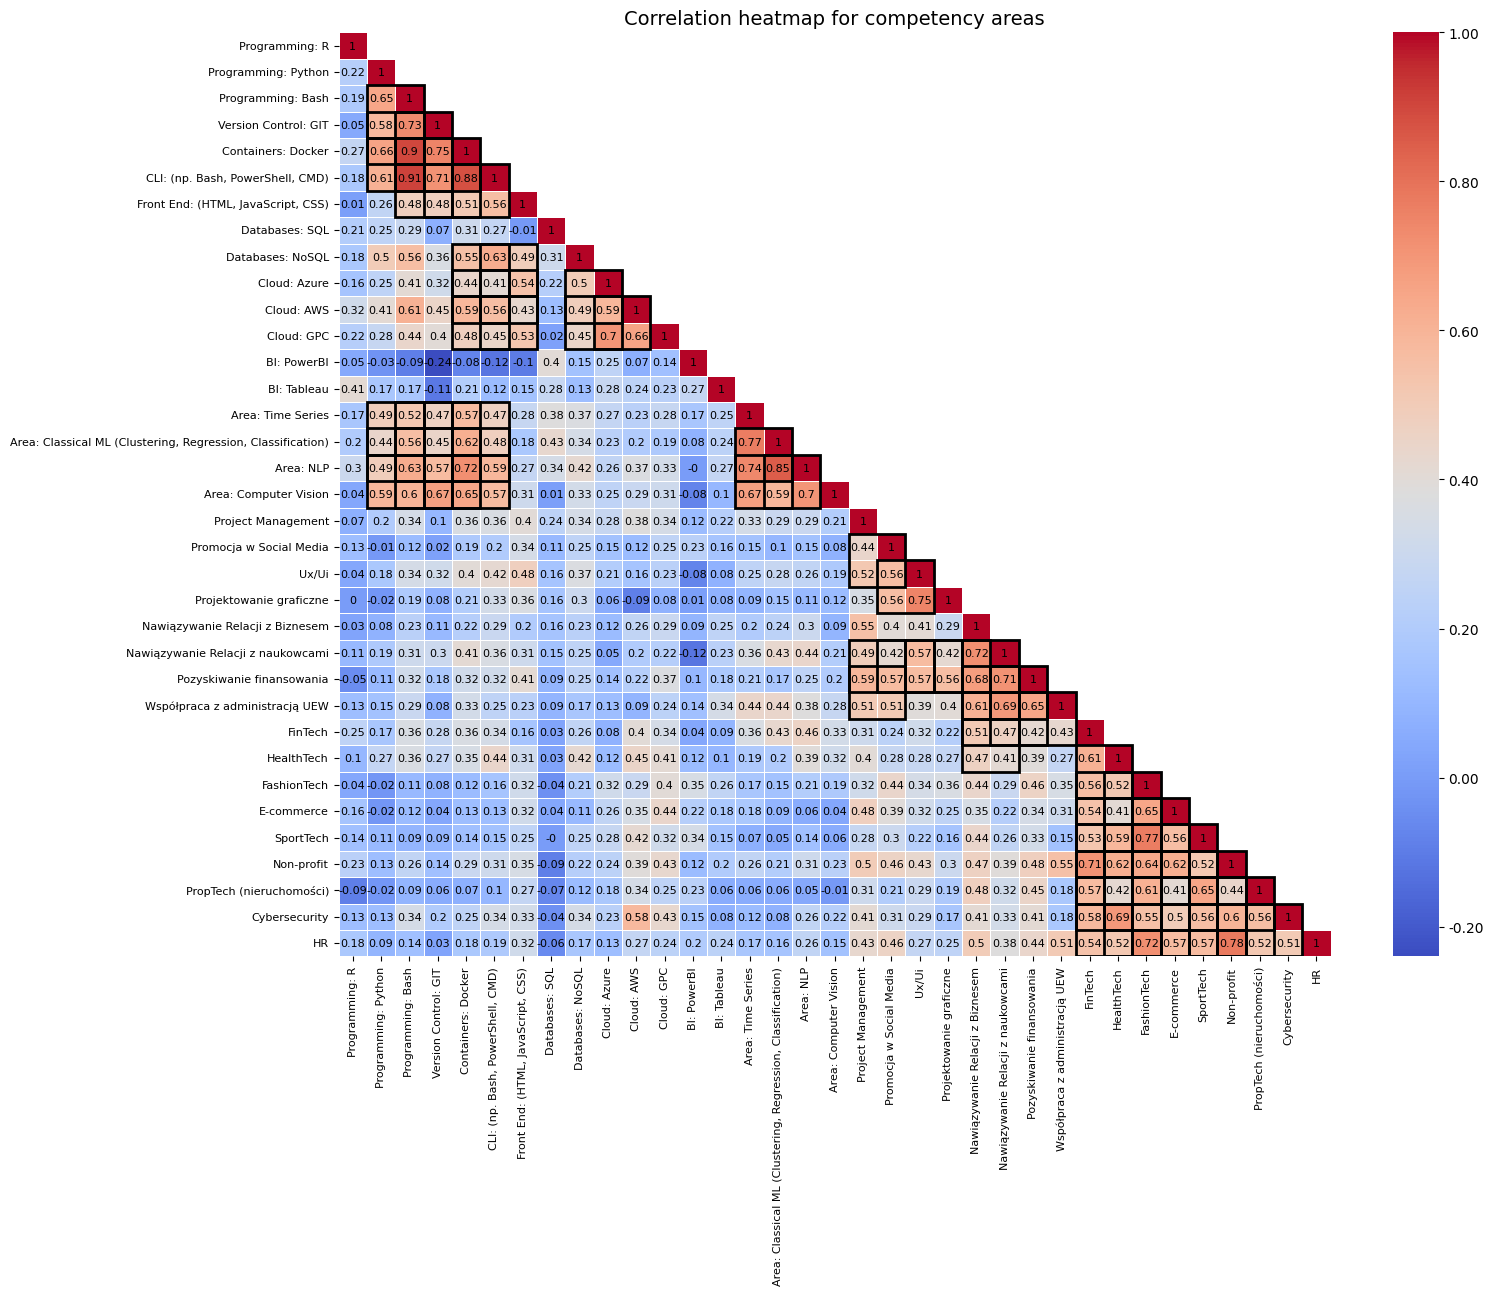

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Dataset loading
data = pd.read_csv(r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\cleaned_dataset.csv')

# Dropping the "ID" column if it exists
if 'ID' in data.columns:
    data = data.drop(columns=['ID'])

# Calculating the correlation matrix and rounding to two decimal places
correlation_matrix = data.corr(numeric_only=True).round(2)

# Custom formatter function to remove trailing zeros
def custom_formatter(x):
    if pd.isna(x):
        return ""
    return ('%.2f' % x).rstrip('0').rstrip('.')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plotting correlation heatmap without annotations and with a mask
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(correlation_matrix, mask=mask, cmap="coolwarm", linewidths=0.5, linecolor='white', annot=False, cbar_kws={'format': '%.2f'})

# Manually adding annotations with custom formatting to the lower triangle and diagonal only
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i >= j:  # Only annotate the lower triangle and diagonal
            text = custom_formatter(correlation_matrix.iloc[i, j])
            heatmap.text(j + 0.5, i + 0.5, text,
                         ha='center', va='center', color='black', fontsize=8)

# Function to add a thick border around a cluster
def add_thick_border(heatmap, cluster_cells, color='black', linewidth=2):
    min_i = min(cell[0] for cell in cluster_cells)
    max_i = max(cell[0] for cell in cluster_cells)
    min_j = min(cell[1] for cell in cluster_cells)
    max_j = max(cell[1] for cell in cluster_cells)
    heatmap.add_patch(plt.Rectangle((min_j, min_i), max_j - min_j + 1, max_i - min_i + 1, fill=False, edgecolor=color, lw=linewidth))

# Finding clusters and drawing thick borders around them
for i in range(correlation_matrix.shape[0] - 1):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > 0.4:
            cluster_cells = [(i, j)]
            if (correlation_matrix.iloc[i + 1, j] > 0.4 and
                correlation_matrix.iloc[i, j + 1] > 0.4 and
                correlation_matrix.iloc[i + 1, j + 1] > 0.4):
                cluster_cells.append((i + 1, j))
                cluster_cells.append((i, j + 1))
                cluster_cells.append((i + 1, j + 1))
                add_thick_border(heatmap, cluster_cells)

plt.title("Correlation heatmap for competency areas", fontsize=14)
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8, rotation=0)
plt.show()

According to the heatmap above, we see some remarkable clusters near the diagonal axis. 
- The most visible one contains of **programming stack**: Python, CLI, Bash, Git and Docker.

- The second cluster is all **Cloud** - GCP, Azure, AWS with addition of NoSQL databases.

- Third noticable cluster is connected strictly to **Data Science** - ML, NLP, Computer Vision, time series.

- Fourth cluster has **soft skills** in it and fifth has **types of industries**.

We can also observe that we don't have any negatively correlated clusters nor values.

It is time to use hierarchical clustering. To be assured of it's best results, I will apply **elbow method** to ensure about the best k-value. I will try two approaches to see which one is more accurate.

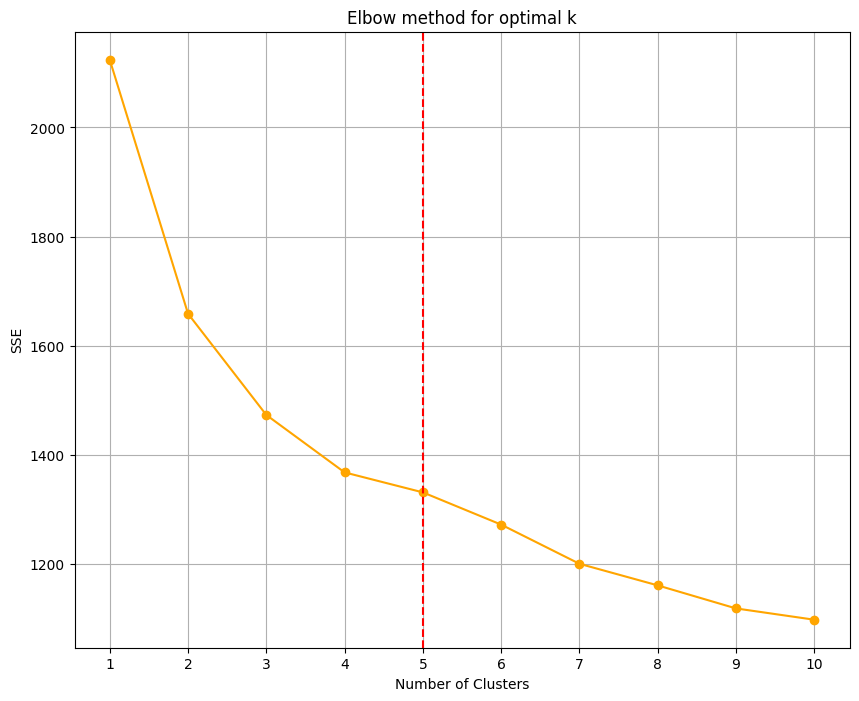

In [23]:
# Re-importing the necessary libraries for clarity and completeness
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the dataset
file_path = r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\cleaned_dataset.csv'
data = pd.read_csv(file_path)

# Dropping non-numeric columns for clustering
numeric_data = data.select_dtypes(include=[np.number])

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Recreating the elbow method plot for clarity
# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Plotting the elbow method results with the requested yellow line and upward line marking the elbow
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), sse, marker='o', color='orange')
plt.title('Elbow method for optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.xticks(range(1, 11))
plt.grid(True)

# Marking the elbow point
optimal_k = np.diff(sse, 2).argmin() + 2  # Adding 2 because np.diff reduces the original array size by 2
plt.axvline(x=optimal_k, color='red', linestyle='--')

plt.show()

According to Sum of Squared Errors method we should take k = 4. Let's visualize the data using dendrogram with four clusters.

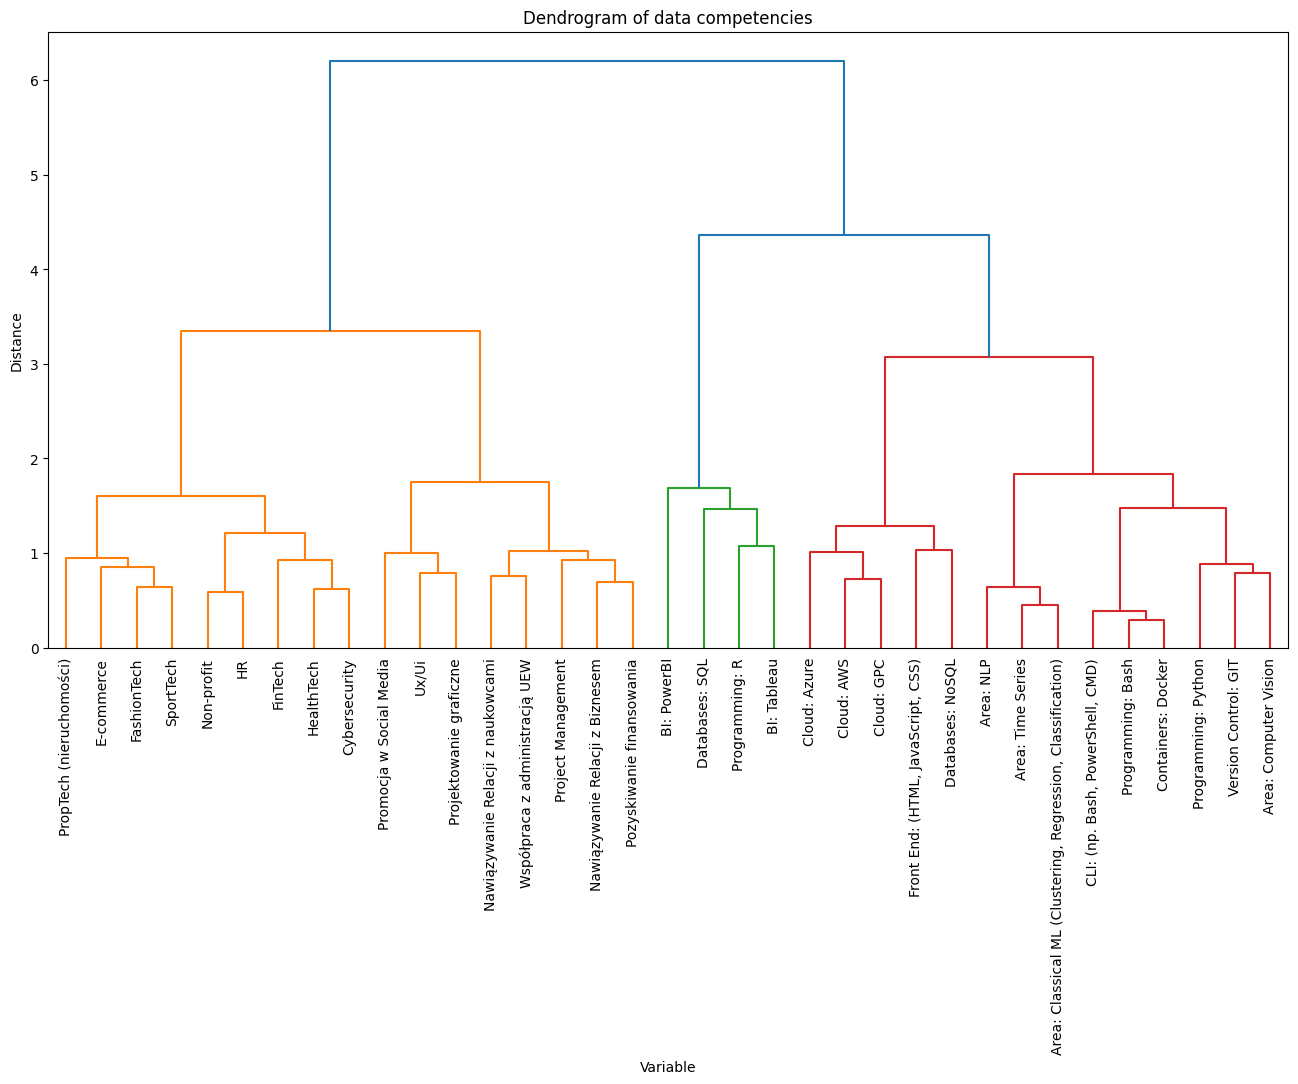

In [25]:
import numpy as np

# Performing hierarchical clustering on the correlation matrix
from scipy.cluster.hierarchy import linkage, dendrogram

# Excluding the ID column from the correlation matrix
correlation_matrix = data.drop(columns=['ID']).corr(numeric_only=True)

# Calculating the linkage matrix
linkage_matrix = linkage(correlation_matrix, method='ward')

# Plotting dendrogram to identify clusters
plt.figure(figsize=(16, 8))
dendro = dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram of data competencies")
plt.xlabel("Variable")
plt.ylabel("Distance")
plt.show()

# Extracting cluster labels for each variable
from scipy.cluster.hierarchy import fcluster
cluster_labels = fcluster(linkage_matrix, t=1.5, criterion='distance')

# Combining cluster labels with the correlation matrix
clustered_data = pd.DataFrame({
    'Variable': correlation_matrix.columns,
    'Cluster': cluster_labels
})

# Sorting variables by cluster
clustered_data = clustered_data.sort_values(by='Cluster').reset_index(drop=True)


Based on dendrogram above we can see that on the left we have a cluster with skills mostly considered as <font color='yellow'>**soft skills**</font> with some exceptions like Cybersecurity, UX/UI and Graphics Design that will be treated as industries in this case.  

On the right side from the middle there is a cluster with <font color='red'>**hard skills**</font>. Green graph, representing <font color='green'>**popular data skills**</font> could be assigned to red as well to match other technical skills. The smaller branch of blue graph clustered technical skills.

Now let's visualize how the answer values distribute over all columns and sort them descendingly.

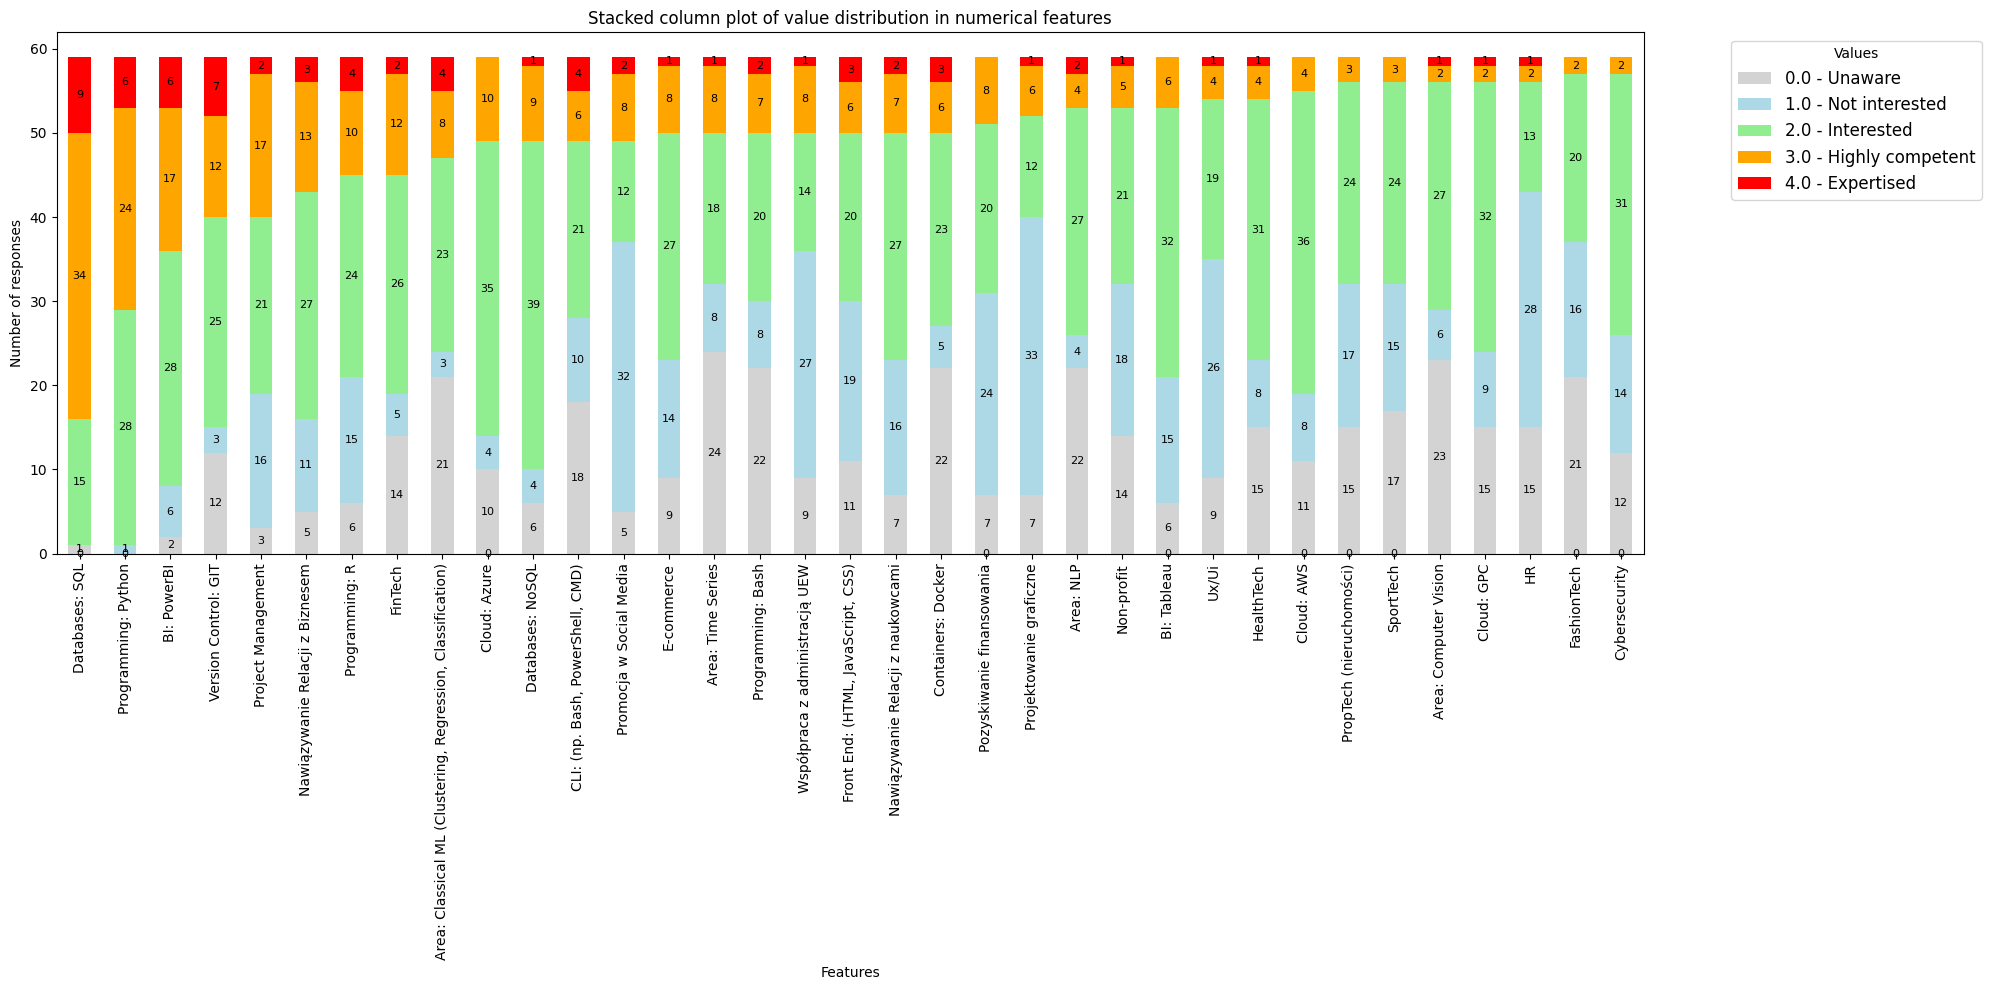

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset loading
data = pd.read_csv(r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\cleaned_dataset.csv')

# Identify numerical columns excluding "ID"
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop('ID')

# Initialize a DataFrame to store the value counts
value_counts = pd.DataFrame(index=[0.0, 1.0, 2.0, 3.0, 4.0])

# Count the occurrences of each value in each numerical column
for column in numeric_columns:
    counts = data[column].value_counts().sort_index()
    value_counts[column] = counts

# Fill NaN values with 0 (for values that do not appear in a column)
value_counts = value_counts.fillna(0)

# Calculate the combined count of 4.0 and 3.0 responses
value_counts.loc['combined'] = value_counts.loc[4.0] + value_counts.loc[3.0]

# Sort the columns based on the combined count of 4.0 and 3.0 responses in descending order
value_counts = value_counts.T.sort_values(by='combined', ascending=False).T
value_counts = value_counts.drop('combined')

# Custom colors for the plot
custom_colors = {
    0.0: 'lightgrey',
    1.0: 'lightblue',
    2.0: 'lightgreen',
    3.0: 'orange',
    4.0: 'red'
}

# Plotting stacked column plot
ax = value_counts.T.plot(kind='bar', stacked=True, figsize=(20, 10), color=[custom_colors[x] for x in value_counts.index])

# Add counts on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=8)

# Titles and labels
plt.title('Stacked column plot of value distribution in numerical features')
plt.xlabel('Features')
plt.ylabel('Number of responses')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [
    '0.0 - Unaware',
    '1.0 - Not interested',
    '2.0 - Interested',
    '3.0 - Highly competent',
    '4.0 - Expertised'
], title='Values', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

plt.tight_layout()
plt.show()


Let's have a closer look into distibution amongst the strongest candidates in the most competitive categories.

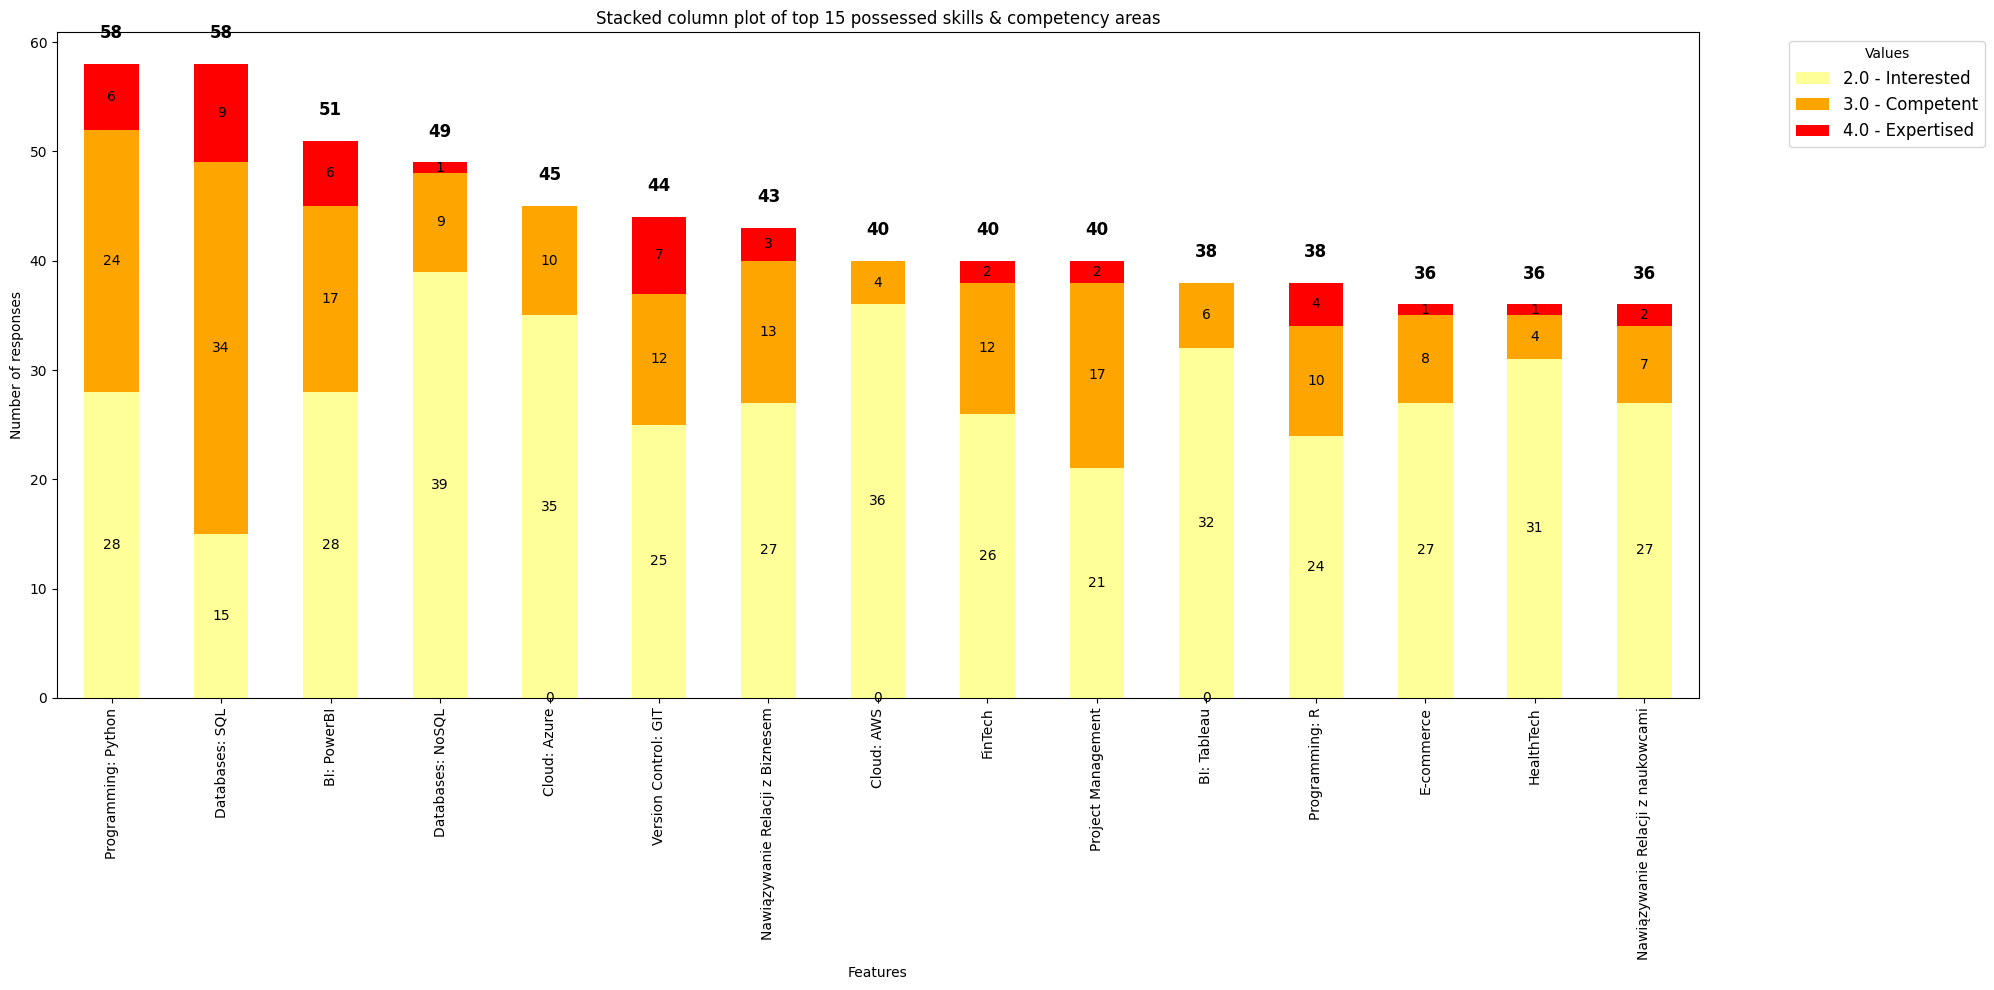

Top 15 categories with the most 4.0, 3.0, and 2.0 responses:
['Programming: Python', 'Databases: SQL', 'BI: PowerBI', 'Databases: NoSQL', 'Cloud: Azure', 'Version Control: GIT', 'Nawiązywanie Relacji z Biznesem', 'Cloud: AWS', 'FinTech', 'Project Management', 'BI: Tableau', 'Programming: R', 'E-commerce', 'HealthTech', 'Nawiązywanie Relacji z naukowcami']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset loading
data = pd.read_csv(r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\cleaned_dataset.csv')

# Identify numerical columns excluding "ID"
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop('ID')

# Initialize a DataFrame to store the value counts
value_counts = pd.DataFrame(index=[2.0, 3.0, 4.0])

# Count the occurrences of each value in each numerical column
for column in numeric_columns:
    counts = data[column].value_counts().sort_index()
    value_counts[column] = counts

# Fill NaN values with 0 (for values that do not appear in a column)
value_counts = value_counts.fillna(0)

# Calculate the combined count of 4.0, 3.0, and 2.0 responses
value_counts.loc['combined'] = value_counts.loc[4.0] + value_counts.loc[3.0] + value_counts.loc[2.0]

# Sort the columns based on the combined count of 4.0, 3.0, and 2.0 responses in descending order
sorted_columns = value_counts.T.sort_values(by='combined', ascending=False).index

# Get the top 15 categories
top_15_columns = sorted_columns[:15]

# Select only the top 15 columns for plotting
value_counts_top_15 = value_counts[top_15_columns]

# Drop the 'combined' row as it is no longer needed
value_counts_top_15 = value_counts_top_15.drop('combined')

# Custom colors for the plot
custom_colors = {
    2.0: '#FFFF99',  # Mellow yellow
    3.0: 'orange',
    4.0: 'red'
}

# Plotting stacked column plot
ax = value_counts_top_15.T.plot(kind='bar', stacked=True, figsize=(20, 10), color=[custom_colors[x] for x in value_counts_top_15.index])

# Annotate the counts on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Annotate the summarized value above each bar in bold
for i, col in enumerate(value_counts_top_15.columns):
    total = value_counts_top_15[col].sum()
    ax.text(i, total + 2, f'{total:.0f}', ha='center', va='bottom', weight='bold', fontsize=12)

# Titles and labels
plt.title('Stacked column plot of top 15 possessed skills & competency areas')
plt.xlabel('Features')
plt.ylabel('Number of responses')
# Adjusted the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['2.0 - Interested', '3.0 - Competent', '4.0 - Expertised'], title='Values', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

plt.tight_layout()
plt.show()

# Display the top 15 columns with the most 4.0, 3.0, and 2.0 responses
print("Top 15 categories with the most 4.0, 3.0, and 2.0 responses:")
print(top_15_columns.tolist())


As observed before, we can confirm a strong representation of candidates in data skills such as: **Python**, **SQL/NoSQL** and **PowerBI**. 

This could lead to a conclusion to focus on building teams with both technical proficiency and data visualisation skills.

##### Based on the graph above we will create the word cloud for skills that have the most 2.0 - 4.0 answers.

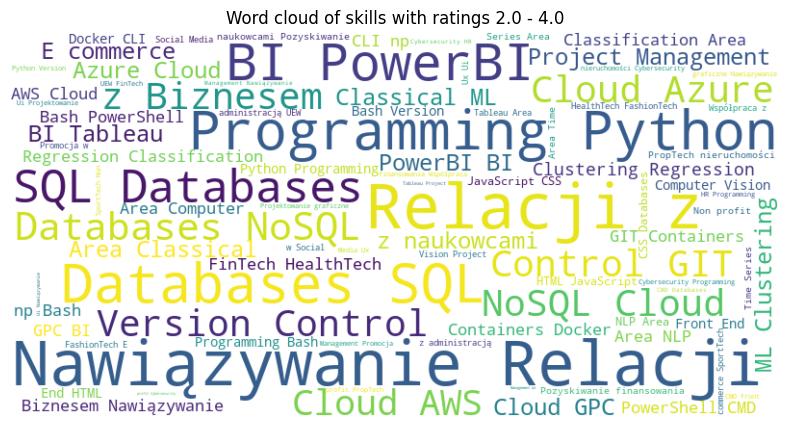

In [28]:
# Import the WordCloud module
from wordcloud import WordCloud

# Ensure the dataset is loaded correctly
data = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')

# Filter the data to include only columns with ratings of 2.0, 3.0, and 4.0 for all categories
filtered_data_all = data[(data == 2.0) | (data == 3.0) | (data == 4.0)]

# Flatten the dataframe and remove NaN values
skill_counts_all = filtered_data_all.stack().dropna()

# Convert the MultiIndex to a simple list of skill names
skill_names_all = skill_counts_all.index.get_level_values(1).tolist()

# Create a word cloud with all skills
wordcloud_all = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(' '.join(skill_names_all))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of skills with ratings 2.0 - 4.0')
plt.show()

We can observe that the biggest words are Programming, Python, SQL Databases, Nawiązywanie relacji z Biznesem, PowerBI.

##### Now let's try to showcase the most correlated pairs of values on a scatter plot and perform regression analysis.

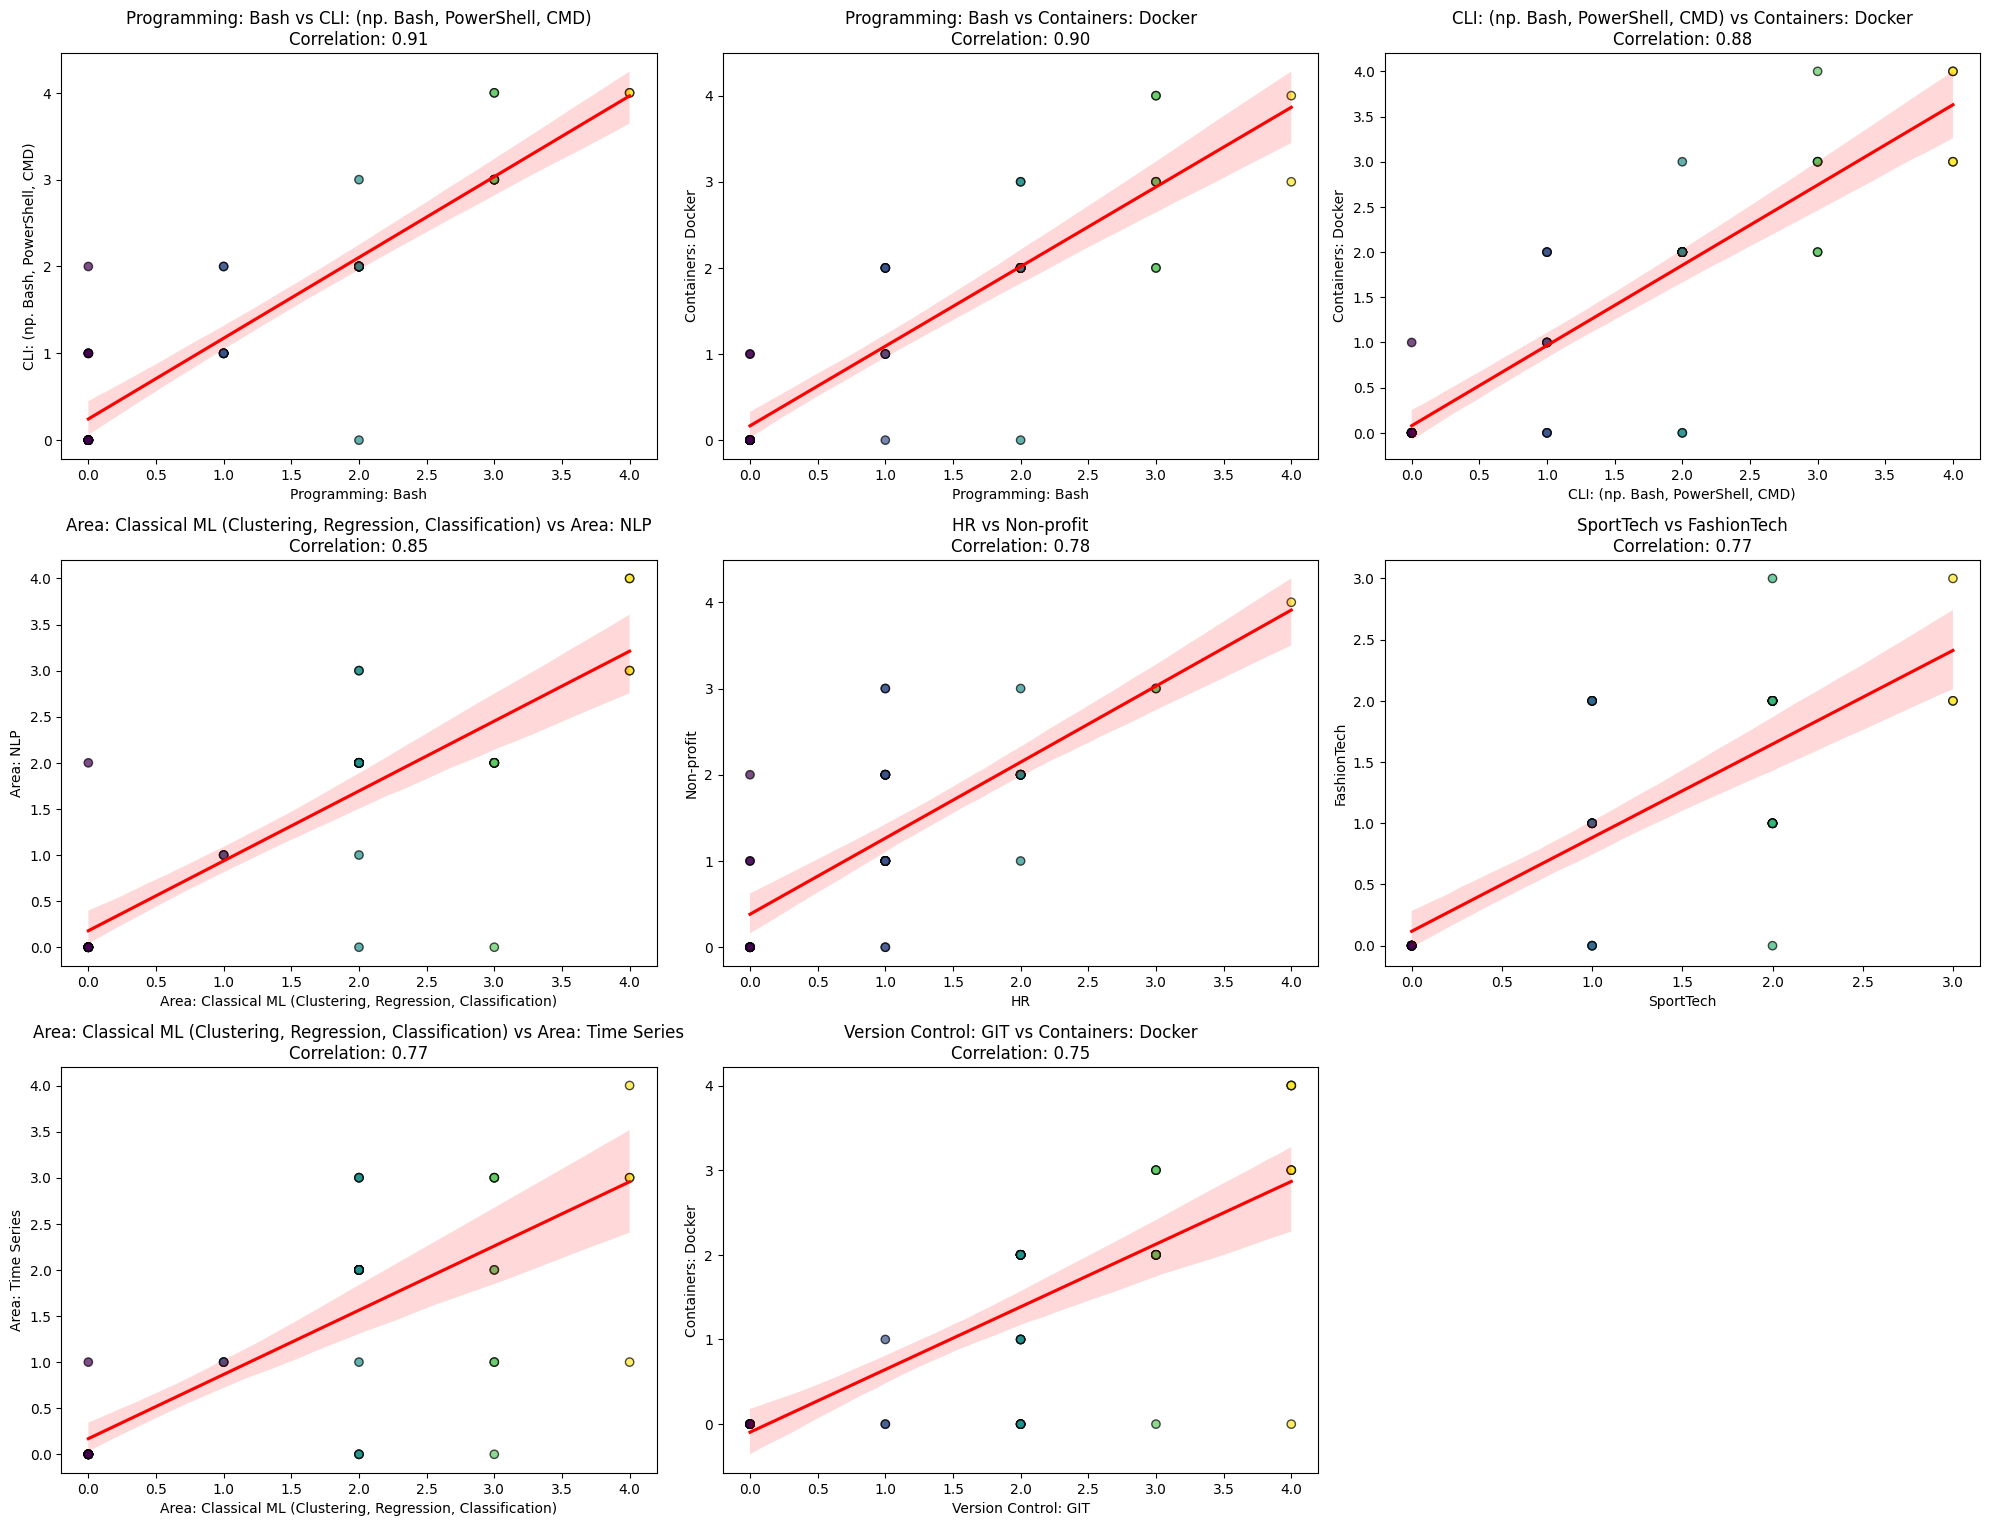

Programming: Bash                                            CLI: (np. Bash, PowerShell, CMD)    0.907887
                                                             Containers: Docker                  0.896332
CLI: (np. Bash, PowerShell, CMD)                             Containers: Docker                  0.882064
Area: Classical ML (Clustering, Regression, Classification)  Area: NLP                           0.850371
HR                                                           Non-profit                          0.778255
SportTech                                                    FashionTech                         0.774723
Area: Classical ML (Clustering, Regression, Classification)  Area: Time Series                   0.765360
Version Control: GIT                                         Containers: Docker                  0.753817
dtype: float64

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
# Ensure the dataset is loaded correctly
df = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')
 
# Define the numerical columns for correlation analysis
numeric_columns = ['Programming: R', 'Programming: Python', 'Programming: Bash', 
                   'Version Control: GIT', 'Containers: Docker', 'CLI: (np. Bash, PowerShell, CMD)', 
                   'Front End: (HTML, JavaScript, CSS)', 'Databases: SQL', 'Databases: NoSQL', 
                   'Cloud: AWS', 'Cloud: GPC', 'BI: PowerBI', 'BI: Tableau', 
                   'Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 
                   'Area: NLP', 'Area: Computer Vision', 'Project Management', 'Promocja w Social Media', 
                   'Ux/Ui', 'Projektowanie graficzne', 'Nawiązywanie Relacji z Biznesem', 
                   'Nawiązywanie Relacji z naukowcami', 'Pozyskiwanie finansowania', 
                   'Współpraca z administracją UEW', 'FinTech', 'HealthTech', 'FashionTech', 
                   'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 
                   'Cybersecurity', 'HR']
 
# Filter the dataset to include only the numerical columns
numeric_data = df[numeric_columns]
 
# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()
 
# Filter pairs with correlation greater than 0.75
high_corr_pairs_filtered_75 = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs_filtered_75 = high_corr_pairs_filtered_75[high_corr_pairs_filtered_75 < 1]  # Exclude self-correlation
high_corr_pairs_filtered_75 = high_corr_pairs_filtered_75[high_corr_pairs_filtered_75 > 0.75].drop_duplicates()
 
# Display the top 12 pairs with the new threshold
top_pairs_75 = high_corr_pairs_filtered_75.head(12)
 
# Plotting scatter plots with regression lines for filtered correlated pairs with the new threshold
plt.figure(figsize=(20, 20))
cmap = 'viridis'  # Define the colormap
 
for i, (pair, corr) in enumerate(top_pairs_75.items()):
    feature1, feature2 = pair
    plt.subplot(4, 3, i+1)
    plt.scatter(numeric_data[feature1], numeric_data[feature2], c=numeric_data[feature1], cmap=cmap, edgecolor='black', alpha=0.7)
    sns.regplot(x=numeric_data[feature1], y=numeric_data[feature2], scatter=False, color='red')
    plt.title(f'{feature1} vs {feature2}\nCorrelation: {corr:.2f}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
plt.tight_layout()
plt.show()
 
# Displaying the top pairs
top_pairs_75

##### General observations:

- There is a strong link between **command-line proficiency** and other technical skills such as **Bash** scripting and **Docker**. This indicates that individuals comfortable with command-line interfaces are likely to engage deeply with other technical tools and automation processes.

- The correlation between areas like **Classical ML** and **NLP**, and **Time Series** analysis with **Classical ML**, suggests that individuals working in these fields often need a broad set of skills and would likely be involved in interdisciplinary projects.

- The correlations observed in sectors like **Non-profit** and **HR**, and **SportTech** and **FashionTech**, reflect specific industry trends where certain roles and technological advancements overlap significantly.

##### Here are the top 8 pairs displayed in the scatter plots:

- **CLI: (np. Bash, PowerShell, CMD)** and **Programming: Bash:** 0.91
  
Strong positive correlation. Users proficient in command-line interfaces are highly likely to have proficiency in Bash scripting.

- **Programming: Bash** and **Containers: Docker:** 0.9
  
Strong correlation between Bash scripting skills and Docker usage, indicating their frequent use together in automation and deployment.

- **CLI: (np. Bash, PowerShell, CMD)** and **Containers: Docker:** 0.88
  
High proficiency in command-line interfaces is strongly linked to Docker usage, reflecting the common use of command-line tools in managing Docker containers.

- **Area: Classical ML (Clustering, Regression, Classification)** and **Area: NLP:** 0.85
  
Significant overlap between classical machine learning techniques and NLP, suggesting that expertise in one often includes the other.

- **Non-profit** and **HR:** 0.78
  
Moderate to strong correlation, potentially indicating a high involvement of HR functions within non-profit organizations.

- **SportTech** and **FashionTech:** 0.77
  
Correlation suggests shared innovation trends and technological overlaps between the sports and fashion tech industries.

- **Area: Time Series** and **Area: Classical ML (Clustering, Regression, Classification):** 0.77
  
Indicates that time series analysis often employs methods from classical ML, showing a significant overlap in methodologies.

- **Version Control: GIT** and **Containers: Docker:** 0.75
  
Moderate to strong correlation, reflecting their essential roles in modern DevOps and CI/CD practices.

##### Let's utilize PCA analysis:

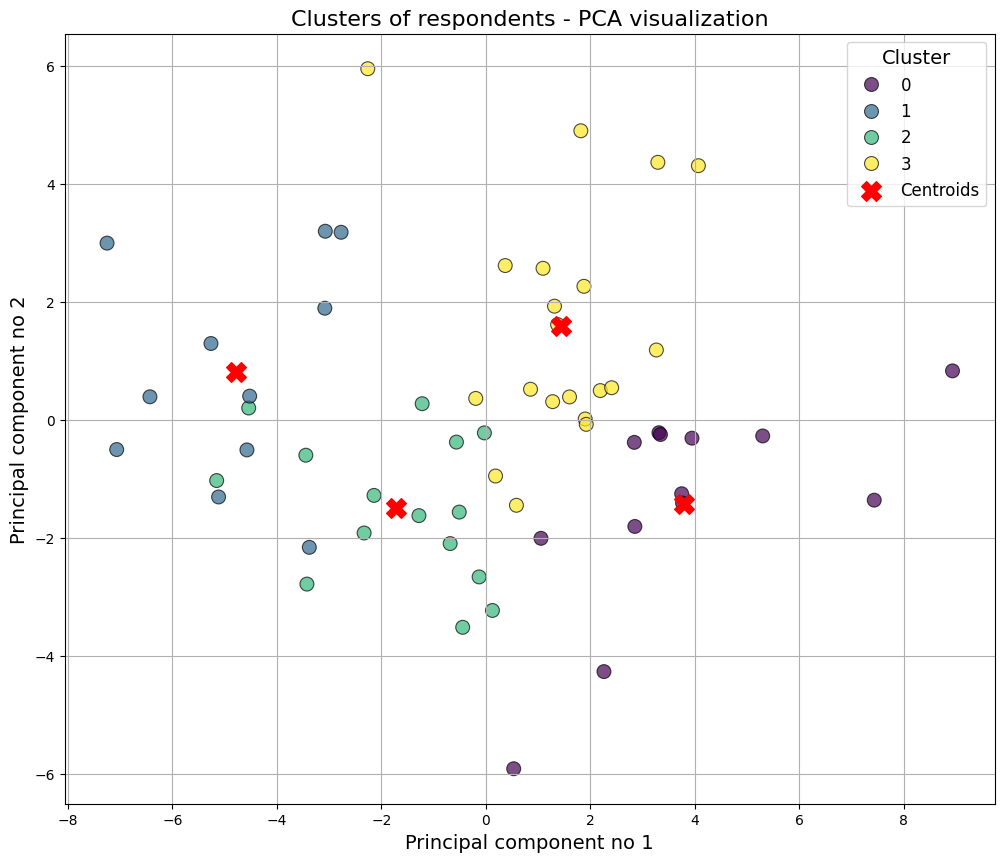

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv(r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\cleaned_dataset.csv')

# List of numerical columns
numerical_columns = ['Programming: R', 'Programming: Python', 'Programming: Bash', 
                     'Version Control: GIT', 'Containers: Docker', 'CLI: (np. Bash, PowerShell, CMD)', 
                     'Front End: (HTML, JavaScript, CSS)', 'Databases: SQL', 'Databases: NoSQL', 
                     'Cloud: Azure', 'Cloud: AWS', 'Cloud: GPC', 'BI: PowerBI', 'BI: Tableau', 
                     'Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 
                     'Area: NLP', 'Area: Computer Vision', 'Project Management', 'Promocja w Social Media', 
                     'Ux/Ui', 'Projektowanie graficzne', 'Nawiązywanie Relacji z Biznesem', 
                     'Nawiązywanie Relacji z naukowcami', 'Pozyskiwanie finansowania', 
                     'Współpraca z administracją UEW', 'FinTech', 'HealthTech', 'FashionTech', 
                     'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 
                     'Cybersecurity', 'HR']

# Standardize the numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_columns])

# Apply KMeans clustering with the optimal number of clusters (assuming 4 based on elbow method)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Apply PCA for dimensionality reduction to visualize the clusters
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
df['PCA1'] = principal_components[:, 0]
df['PCA2'] = principal_components[:, 1]

# Improved visualization of the clusters
plt.figure(figsize=(12, 10))
palette = sns.color_palette("viridis", as_cmap=True)
scatter = sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette=palette, s=100, edgecolor='k', alpha=0.7)

# Add centroids of the clusters
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', label='Centroids', marker='X')

# Adding titles and labels
plt.title('Clusters of respondents - PCA visualization', fontsize=16)
plt.xlabel('Principal component no 1', fontsize=14)
plt.ylabel('Principal component no 2', fontsize=14)

# Enhancing the legend
plt.legend(title='Cluster', title_fontsize='14', fontsize='12', loc='best')
plt.grid(True)
plt.show()

**Cluster 0**: Respondents with a balanced set of skills and proficiencies across various areas.

**Cluster 1**: Contains respondents who may be beginners or have lower proficiency in many areas.

**Cluster 2**: Includes respondents who are highly proficient in certain areas or have specialized skills.

**Cluster 3**: Comprises respondents with a mix of moderate to high skills in various areas, similar to cluster 0 but with distinct differences

Centroids marked on the graph are centres of each cluster.

##### For better understading of distribution of skills amongst different clusters I will use violin plots.

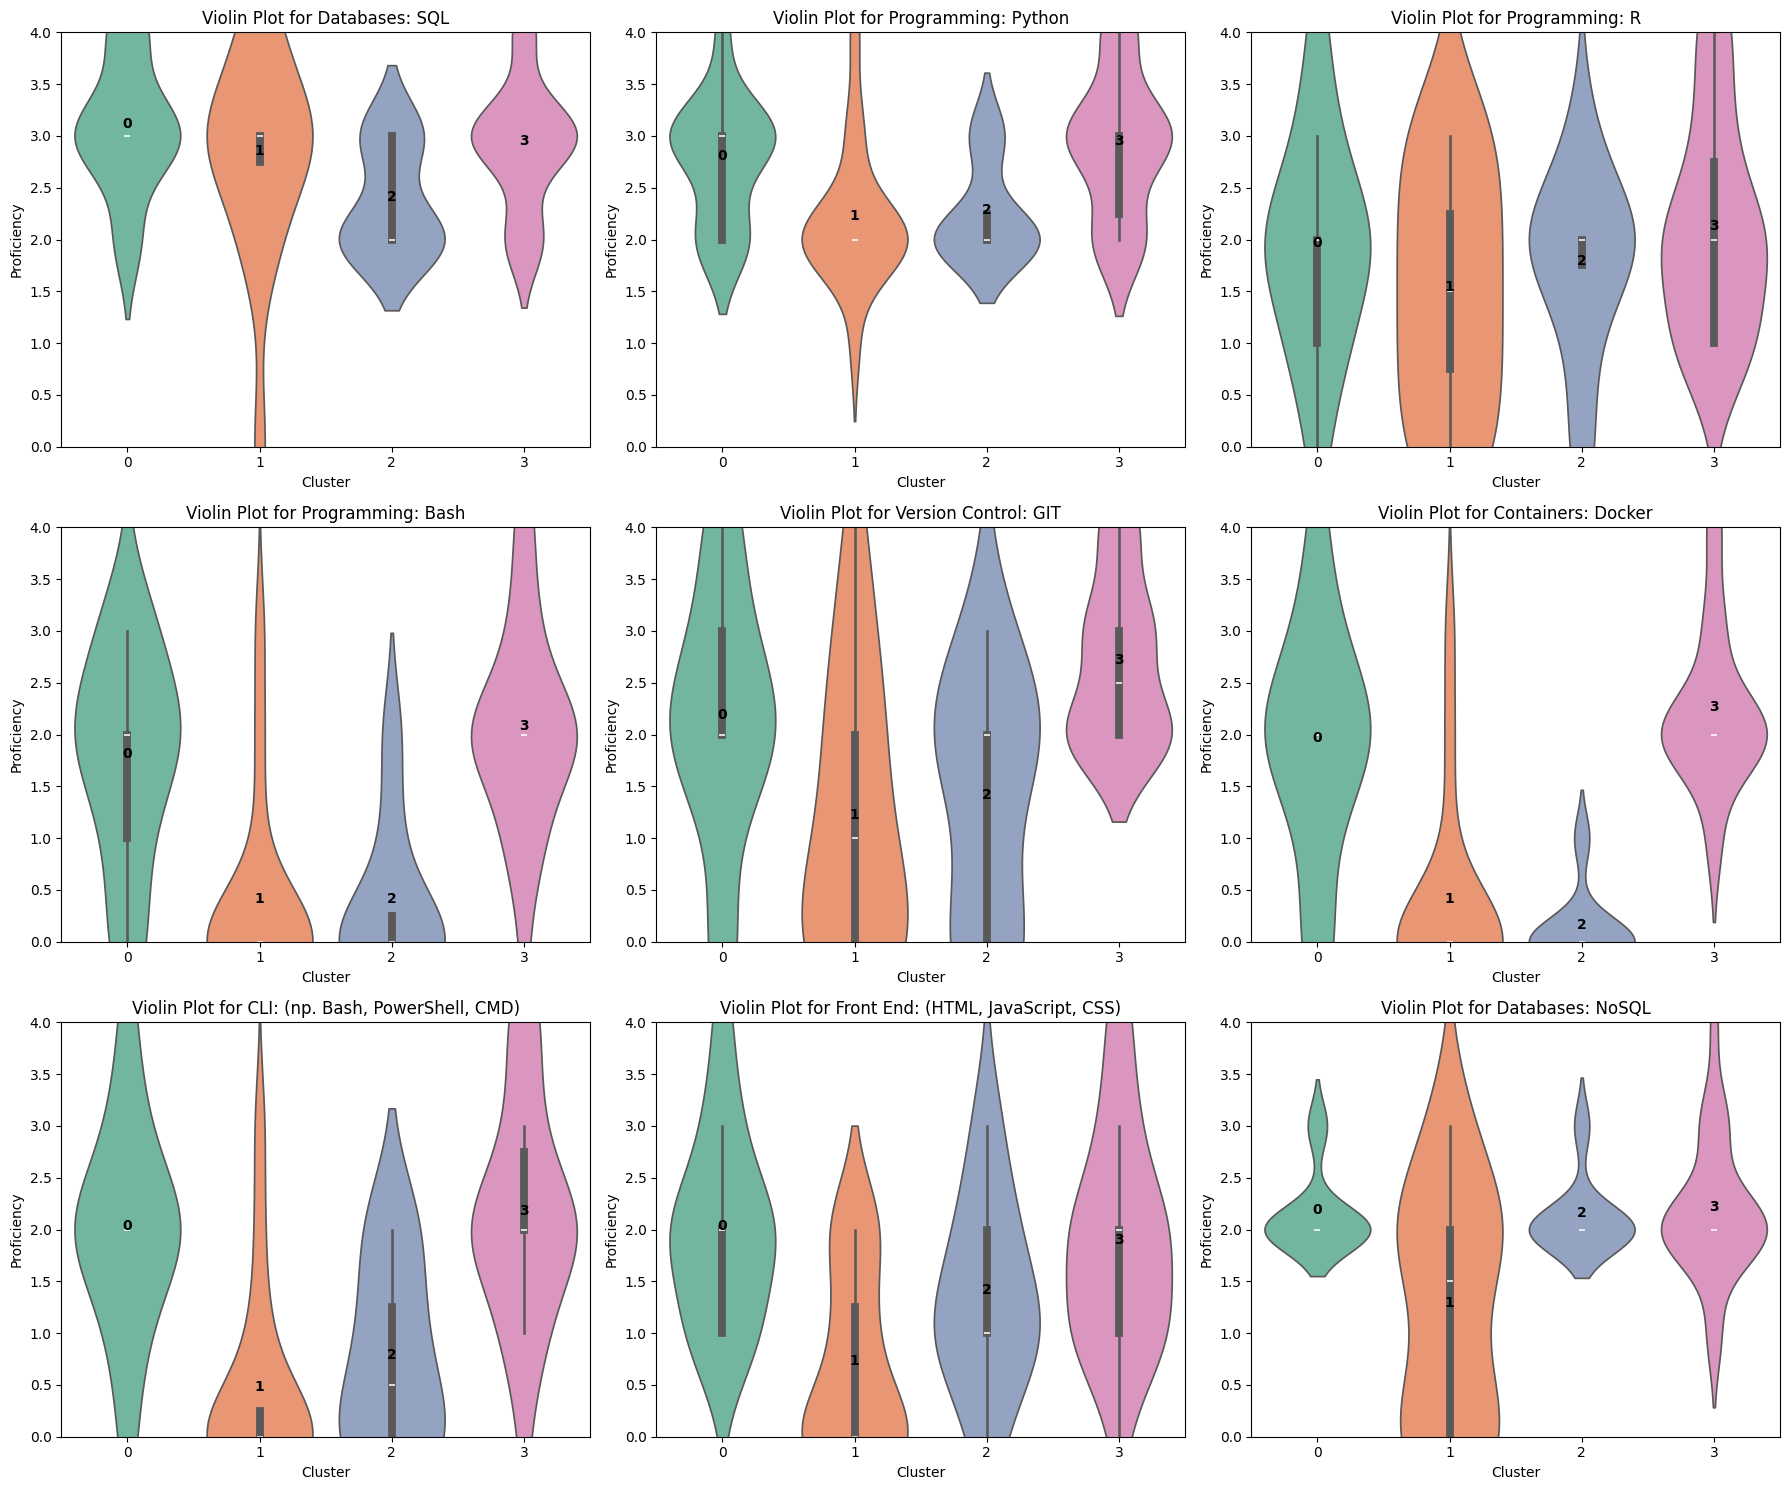

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the dataset
df = pd.read_csv(r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\cleaned_dataset.csv')

# Define the numerical columns for skill analysis
skill_columns = ['Programming: R', 'Programming: Python', 'Programming: Bash', 
                 'Version Control: GIT', 'Containers: Docker', 'CLI: (np. Bash, PowerShell, CMD)', 
                 'Front End: (HTML, JavaScript, CSS)', 'Databases: SQL', 'Databases: NoSQL', 
                 'Cloud: AWS', 'Cloud: GPC', 'BI: PowerBI', 'BI: Tableau', 
                 'Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 
                 'Area: NLP', 'Area: Computer Vision', 'Project Management', 'Promocja w Social Media', 
                 'Ux/Ui', 'Projektowanie graficzne', 'Nawiązywanie Relacji z Biznesem', 
                 'Nawiązywanie Relacji z naukowcami', 'Pozyskiwanie finansowania', 
                 'Współpraca z administracją UEW', 'FinTech', 'HealthTech', 'FashionTech', 
                 'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 
                 'Cybersecurity', 'HR']

# Standardize the numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[skill_columns])

# Apply KMeans clustering with the optimal number of clusters (assuming 4 based on elbow method)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Identify the best skills from each cluster
best_skills = df.groupby('Cluster')[skill_columns].mean().idxmax(axis=1).unique()

# Prepare data for violin plots
melted_df = df.melt(id_vars=['Cluster'], value_vars=skill_columns, var_name='Skill', value_name='Proficiency')

# Combine the best skills with some additional unique skills, excluding 'Cloud: Azure'
additional_skills = [skill for skill in skill_columns if skill not in best_skills][:9 - len(best_skills)]  # Ensure we get 9 unique skills in total
selected_skills = list(best_skills) + additional_skills

# Define a custom color palette with 4 distinct colors
custom_palette = sns.color_palette("Set2", 4)  # Using 'Set2' for distinct colors

# Plot violin plots for the selected skills
plt.figure(figsize=(18, 15))
for i, skill in enumerate(selected_skills, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(x='Cluster', y='Proficiency', hue='Cluster', data=melted_df[melted_df['Skill'] == skill], palette=custom_palette, legend=False)
    plt.title(f'Violin Plot for {skill}')
    plt.xlabel('Cluster')
    plt.ylabel('Proficiency')
    plt.ylim(0, 4)  # Set y-axis limits from 0 to 4

    # Adding cluster labels inside the plot
    cluster_means = df.groupby('Cluster')[skill].mean()
    for cluster, mean in cluster_means.items():
        plt.text(cluster, mean, f'{cluster}', horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.tight_layout()
plt.show()

**Cluster 0** consistently shows higher proficiency in a broader range of skills, indicating a well-rounded skill set among respondents.

**Cluster 1** also shows high proficiency in several key areas but is slightly less consistent compared to **Cluster 0**.

**Cluster 2** and **Cluster 3** generally show lower proficiency across most skills, suggesting that these respondents might be more specialized or less experienced in these areas.

The violin plots reveal the distribution of skills within each cluster, highlighting that even within a cluster, there can be significant variation in proficiency levels.
These insights can be useful for targeted interventions, such as:

Providing advanced training in specific skills for **Cluster 2** and **Cluster 3** to bring their proficiency levels up.
Encouraging knowledge sharing and mentorship from **Cluster 0** and **Cluster 1** to other clusters.
Identifying areas where the community as a whole might need additional resources or support.

Now let's compare competencies amongst all individuals:

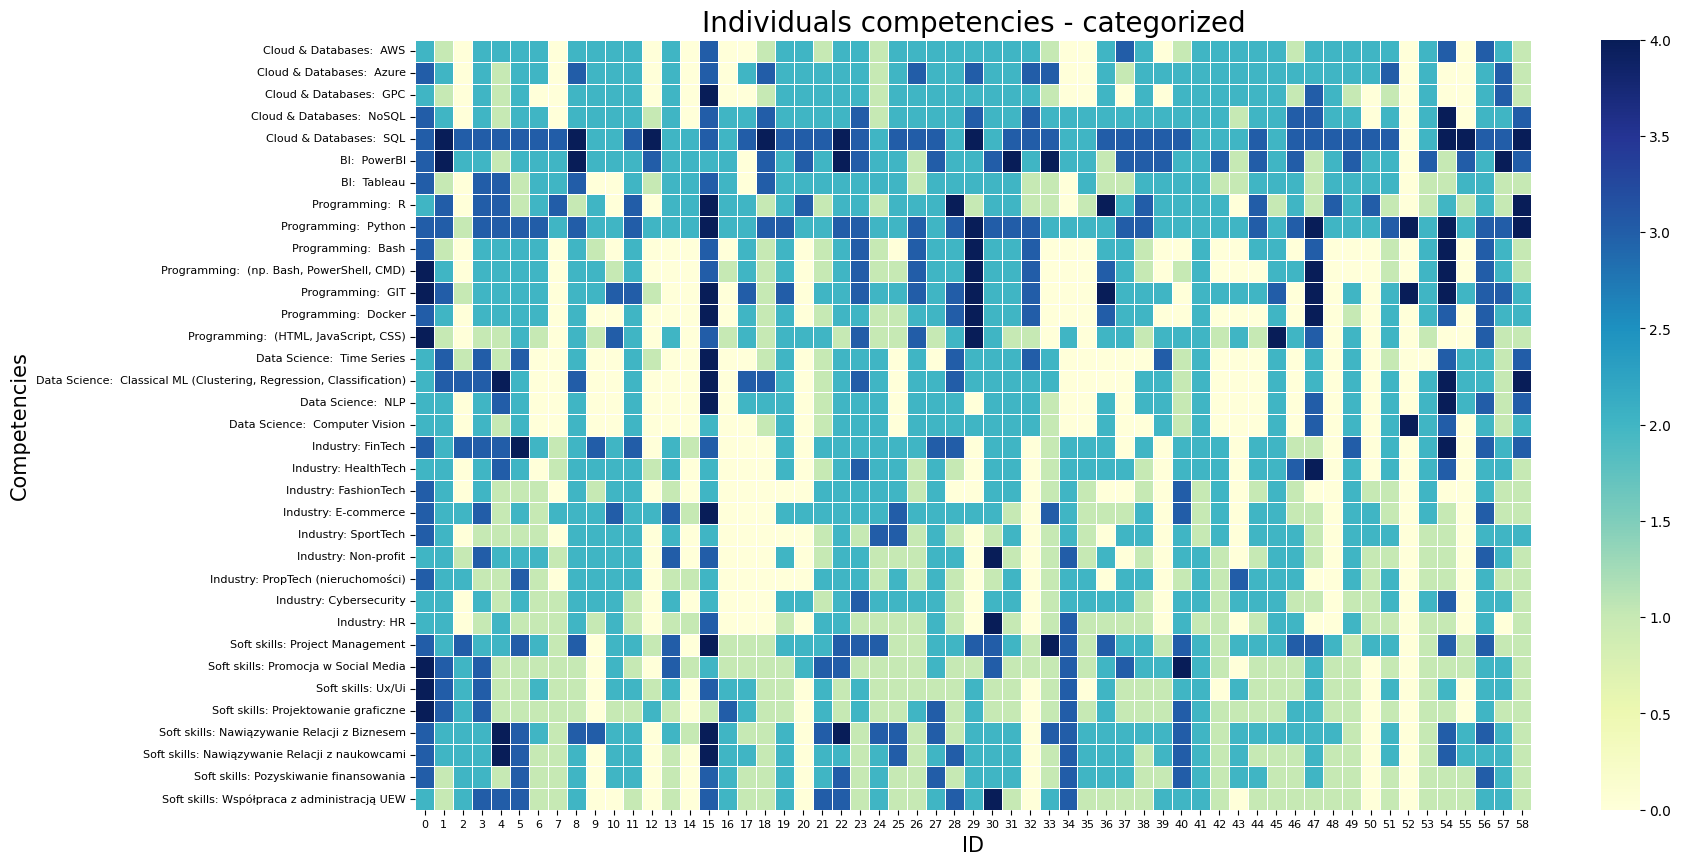

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv(r'D:\Users\Desktop\ProjektAnalitiks\data\02_Interim\cleaned_dataset.csv')

# Define the updated categories with original names for columns
categories_updated = {
    'Cloud & Databases': ['Cloud: AWS', 'Cloud: Azure', 'Cloud: GPC', 'Databases: NoSQL', 'Databases: SQL'],
    'BI': ['BI: PowerBI', 'BI: Tableau'],
    'Programming': ['Programming: R', 'Programming: Python', 'Programming: Bash', 'CLI: (np. Bash, PowerShell, CMD)', 'Version Control: GIT', 'Containers: Docker', 'Front End: (HTML, JavaScript, CSS)'],
    'Data Science': ['Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 'Area: NLP', 'Area: Computer Vision'],
    'Industry': ['FinTech', 'HealthTech', 'FashionTech', 'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 'Cybersecurity', 'HR'],
    'Soft skills': ['Project Management','Promocja w Social Media','Ux/Ui','Projektowanie graficzne','Nawiązywanie Relacji z Biznesem','Nawiązywanie Relacji z naukowcami','Pozyskiwanie finansowania','Współpraca z administracją UEW']
}

# Ensure all columns in the categories are present in the data
selected_columns = [col for sublist in categories_updated.values() for col in sublist if col in data.columns]

# Select only the columns that fall into the defined categories
heatmap_data_filtered = data[selected_columns]

# Generate a new mapping for column names with category as prefix
column_category_mapping = {}
for category, columns in categories_updated.items():
    for column in columns:
        if column in data.columns:
            column_category_mapping[column] = f"{category}: {column.split(':')[-1]}"

# Rename columns with new category mapping
heatmap_data_renamed = heatmap_data_filtered.rename(columns=column_category_mapping)

# Generate the heatmap with new column names
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data_renamed.T, cmap='YlGnBu', cbar=True, annot=False, fmt="d", linewidths=.5)

plt.title('Individuals competencies - categorized', fontsize=20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('ID', fontsize=15)
plt.ylabel('Competencies', fontsize=15)
plt.show()

Heatmap generated above is a great starting point for further drill down and a posibility to check which individuals can be grouped together based on their skillsets.

##### At the end of this **Advanced EDA** chapter, we can create custom groups based on **selected groups of skills**. 

##### These groups will prioritize strong individuals with skills rated between 2 and 4. 

##### You can adjust:

- the number of people in these groups (between 2 and 10),
- the minimum number of 4.0 responses in created groups.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the dataset
data = pd.read_csv(r'C:\Users\rejen\OneDrive\Documents\GitHub\ProjektAnalitiks\data\03_Processed\cleaned_data.csv')

# Define the updated categories with original names for columns
categories_updated = {
    'Cloud & Databases': ['Cloud: AWS', 'Cloud: Azure', 'Cloud: GPC', 'Databases: NoSQL', 'Databases: SQL'],
    'Business Intelligence (BI)': ['BI: PowerBI', 'BI: Tableau'],
    'Programming': ['Programming: R', 'Programming: Python', 'Programming: Bash', 'CLI: (np. Bash, PowerShell, CMD)', 'Version Control: GIT', 'Containers: Docker', 'Front End: (HTML, JavaScript, CSS)'],
    'Data Science': ['Area: Time Series', 'Area: Classical ML (Clustering, Regression, Classification)', 'Area: NLP', 'Area: Computer Vision'],
    'Industry knowledge': ['FinTech', 'HealthTech', 'FashionTech', 'E-commerce', 'SportTech', 'Non-profit', 'PropTech (nieruchomości)', 'Cybersecurity', 'HR'],
    'Soft skills': ['Project Management','Promocja w Social Media','Ux/Ui','Projektowanie graficzne','Nawiązywanie Relacji z Biznesem','Nawiązywanie Relacji z naukowcami','Pozyskiwanie finansowania','Współpraca z administracją UEW']
}

# Create a custom colormap
cmap = mcolors.ListedColormap(['#FFFFE0', '#90EE90', '#006400'])
norm = mcolors.BoundaryNorm([2, 3, 4, 5], cmap.N)

# Create custom legend patches
legend_patches = [
    Patch(color='#FFFFE0', label='2.0 - Interested'),
    Patch(color='#90EE90', label='3.0 - Competent'),
    Patch(color='#006400', label='4.0 - Expert')
]

def process_category(category_name, columns, min_group_size, max_group_size, min_4_0_answers):
    competencies_data = data[columns]

    # Filter out 0.0 and 1.0 competencies
    filtered_data = competencies_data.apply(lambda col: col.map(lambda x: x if x in [2, 3, 4] else np.nan)).dropna(how='all', axis=1)

    # Normalize the data
    scaler = StandardScaler()
    competencies_scaled = scaler.fit_transform(filtered_data.fillna(0))

    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(competencies_scaled)

    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5, linkage='average')
    clustering.fit(similarity_matrix)

    # Assign groups based on clustering
    data['Group'] = clustering.labels_

    # Filter out groups with less than min_group_size people
    group_sizes = data['Group'].value_counts()
    valid_groups = group_sizes[group_sizes >= min_group_size].index
    data_valid = data[data['Group'].isin(valid_groups)]

    # Split larger groups into smaller ones if necessary, ensuring each group has at least min_4_0_answers 4.0 values
    new_groups = []
    for group in valid_groups:
        group_data = data_valid[data_valid['Group'] == group]
        group_size = len(group_data)
        while group_size > max_group_size:
            high_competency = group_data[columns].apply(lambda row: (row == 4.0).sum() >= min_4_0_answers, axis=1)
            if high_competency.sum() == 0:
                break
            
            high_comp_individuals = group_data[high_competency]
            remaining_individuals = group_data[~high_competency]
            
            if len(high_comp_individuals) >= max_group_size:
                new_groups.append(high_comp_individuals.iloc[:max_group_size])
                group_data = group_data.iloc[max_group_size:]
            else:
                split_group = pd.concat([high_comp_individuals, remaining_individuals.iloc[:max_group_size - len(high_comp_individuals)]])
                new_groups.append(split_group)
                group_data = remaining_individuals.iloc[max_group_size - len(high_comp_individuals):]
            
            group_size = len(group_data)
        
        if group_size >= min_group_size and (group_data[columns] == 4.0).sum(axis=1).max() >= min_4_0_answers:
            new_groups.append(group_data)

    # Plot heatmaps for each new group, showing only the best skills
    group_counter = 1
    for group_data in new_groups:
        group_ids = group_data['ID']
        group_competencies = group_data[columns]

        # Filter competencies to only include those rated 2, 3, or 4
        best_competencies = group_competencies.apply(lambda col: col.map(lambda x: x if x in [2, 3, 4] else np.nan))
        best_competencies = best_competencies.dropna(how='all').dropna(axis=1, how='all')

        if (best_competencies == 4.0).sum().sum() < min_4_0_answers:
            continue

        sorted_competencies = best_competencies.apply(lambda col: col.sort_values(ascending=False), axis=0)

        if not sorted_competencies.empty:
            heatmap_data_renamed = sorted_competencies.set_index(group_ids)

            plt.figure(figsize=(14, 8))
            sns.heatmap(heatmap_data_renamed.T, cmap=cmap, norm=norm, cbar=False, annot=True, fmt=".1f", linewidths=.5)
            plt.title(f'{category_name} - group nr {group_counter} - top competency', fontsize=20)
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
            plt.xlabel('ID', fontsize=15)
            plt.ylabel('Competencies', fontsize=15)
            plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
            plt.show()
            group_counter += 1

# Function to create checkboxes for category selection
def choose_skill_categories():
    label = widgets.HTML(value="<b>Select desired skills for grouping process:</b>")
    category_checkboxes = {category: widgets.Checkbox(value=False, description=category, 
                                                      style={'description_width': 'initial'}) for category in categories_updated.keys()}
    checkboxes = widgets.VBox([label] + list(category_checkboxes.values()), layout=widgets.Layout(padding='10px', border='solid 1px #ccc', margin='10px'))
    
    min_group_size_slider = widgets.IntSlider(value=2, min=2, max=10, step=1, description='Min. group size:', 
                                              style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))
    max_group_size_slider = widgets.IntSlider(value=4, min=2, max=10, step=1, description='Max. group size:', 
                                              style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))
    min_4_0_answers_slider = widgets.IntSlider(value=2, min=0, max=9, step=1, description='Min. 4.0 answers:', 
                                               style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))
    
    button = widgets.Button(description="Generate heatmaps", button_style='success', 
                            layout=widgets.Layout(width='200px', margin='10px 0px 10px 0px'))

    output = widgets.Output()

    def on_button_click(b):
        selected_categories = [category for category, checkbox in category_checkboxes.items() if checkbox.value]
        selected_skills = sum([categories_updated[category] for category in selected_categories], [])
        min_group_size = min_group_size_slider.value
        max_group_size = max_group_size_slider.value
        min_4_0_answers = min_4_0_answers_slider.value
        with output:
            clear_output(wait=True)
            if selected_skills:
                process_category('Custom selection', selected_skills, min_group_size, max_group_size, min_4_0_answers)
            else:
                display(widgets.HTML("<p style='color:red;'><b>Please select at least one category.</b></p>"))

    def on_checkbox_change(change):
        checkbox = change['owner']
        if checkbox.value:
            checkbox.layout.border = '2px solid green'
        else:
            checkbox.layout.border = ''

    for checkbox in category_checkboxes.values():
        checkbox.observe(on_checkbox_change, names='value')

    def on_min_group_size_change(change):
        min_value = change['new']
        if min_value > max_group_size_slider.value:
            max_group_size_slider.value = min_value

    def on_max_group_size_change(change):
        max_value = change['new']
        if max_value < min_group_size_slider.value:
            min_group_size_slider.value = max_value

    min_group_size_slider.observe(on_min_group_size_change, names='value')
    max_group_size_slider.observe(on_max_group_size_change, names='value')

    button.on_click(on_button_click)

    display(checkboxes, min_group_size_slider, max_group_size_slider, min_4_0_answers_slider, button, output)

choose_skill_categories()


IntSlider(value=2, description='Min. group size:', layout=Layout(width='300px'), max=10, min=2, style=SliderSt…

IntSlider(value=4, description='Max. group size:', layout=Layout(width='300px'), max=10, min=2, style=SliderSt…

IntSlider(value=2, description='Min. 4.0 answers:', layout=Layout(width='300px'), max=9, style=SliderStyle(des…

Button(button_style='success', description='Generate heatmaps', layout=Layout(margin='10px 0px 10px 0px', widt…

Output()

## **Conclusion**

Data cleaning has made significant changes to the dataset, leaving only rows and columns with non-missing values to ensure quality presentation of data on further stages.

In chapter "**Exploratory Data Analysis**" we performed a series of basic, as well as advanced data exploration and visualization techniques. After each analysis there is a visualization and simple summary to present insights that were collected.

EDA section covered some of the most useful techniques for data visualisation, such as: **heatmap** (for visualising correlation and missing values), simple **bar charts** and **column charts**, **box-plots**, **scatter plots**, **violin plots**, **stacked column plots**, **line plots** or **dendrogram**. 

It also covered some basic forms of scientific approach to data in forms of: **clustering**, **outlier detection**, **data imputation**, **PCA** and **regression analysis**.



Based on the results presented above, there is a general consensus that the team consists of well-skilled individuals - especially in technical fields of programming, data science, cloud and business intelligence.